In [1]:
import sys
sys.path.append('../')

import yaml
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, SkyOffsetFrame, EarthLocation, AltAz

from matplotlib import pyplot

from srcsim.mc import MCEvents
from srcsim.src import generator as srcgen
from srcsim.run import DataRun

# Simulation

Global configuration defining what will be simulated

In [2]:
cfg = yaml.load(open('run_example.yaml', "r"), Loader=yaml.FullLoader)

### MC file

In [3]:
mcevents = MCEvents('dl2_gamma-diffuse_testing.h5')
mcevents

MCEvents instance
    File name...........: dl2_gamma-diffuse_testing.h5
    Obs IDs.............: (1001, 1002, 1008, 1012, 1016)
    Azimuth range.......: 180.00 deg - 180.00 deg
    Altitude range......: 70.00 deg - 70.00 deg



### Source

In [4]:
src = srcgen(cfg['source'])
src

GaussSource instance
    Position............: <SkyCoord (ICRS): (ra, dec) in deg
    (83., 22.)>
    Sigma...............: 0.5 deg



### Data "run"

Can define a run by hand...

In [5]:
# #Can define a run by hand...
# lst_loc = EarthLocation(lat=28.761758*u.deg, lon=-17.890659*u.deg, height=2200*u.m)
# run = DataRun(
#     SkyCoord(83, 21, unit='deg', frame='icrs'),
#     Time('2022-05-31T15:00:00'),
#     Time('2022-05-31T15:20:00'),
#     lst_loc
# )

... but better take the settings from the specified configuration.

In [6]:
run = DataRun.from_config(cfg['run'])
run

DataRun instance
    Tel. RA/Dec.........: <SkyCoord (ICRS): (ra, dec) in deg
    (83., 21.)>
    Tstart..............: 2022-05-31T15:00:00.000
    Tstop...............: 2022-05-31T15:20:00.000
    Tel. azimuth........: [239.30 deg - 248.48 deg]
    Tel. alt............: [76.00 deg - 72.05 deg]



### Simulation...

In [7]:
events = run.get_events(
    mcevents,
    src,
)

/usr/lib/python3/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


# Ploting the simulated events

In [8]:
lst_focal_length = 29.5 * u.m
cam2angle = 1 * u.rad / lst_focal_length
cam_x, cam_y = events[['reco_src_x', 'reco_src_y']].to_numpy().transpose() * u.m * cam2angle

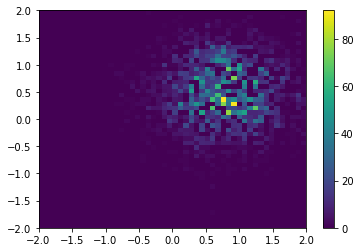

In [9]:
pyplot.hist2d(
    cam_x.to('deg').value,
    cam_y.to('deg').value,
    range=(
        (-2, 2),
        (-2, 2)
    ),
    bins=50
);
pyplot.colorbar()

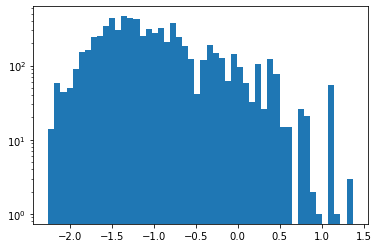

In [10]:
pyplot.semilogy()
pyplot.hist(
    np.log10(events['mc_energy']),
    # np.log10(mcevents.samples[0].data_table['mc_energy']),
    bins=50
);

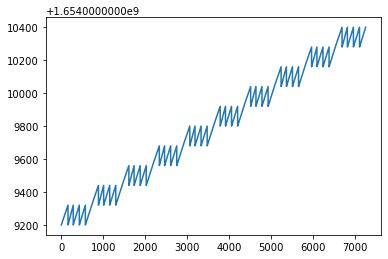

In [11]:
pyplot.plot(
    events['dragon_time'].to_numpy(),
)